In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import gdown
from pathlib import Path

In [ ]:
os.makedirs("asl")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile("/content/drive/MyDrive/ZipFiles/cosine_v4.zip", "r") as zipobj:
    zipobj.extractall("asl")

In [ ]:
data_dir = '/content/asl/cosine'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed=123,
    image_size=(256, 256),
    batch_size=64
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256,256),
    batch_size=64
    )
class_names = train_ds.class_names
print(class_names)

Found 1121 files belonging to 2 classes.
Using 897 files for training.
Found 1121 files belonging to 2 classes.
Using 224 files for validation.
['a', 'b']


Epoch 1/100
15/15 [==============================] - 2s 104ms/step - loss: 0.6959 - accuracy: 0.4649 - val_loss: 0.6913 - val_accuracy: 0.5804
Epoch 2/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6936 - accuracy: 0.4950 - val_loss: 0.6933 - val_accuracy: 0.4598
Epoch 3/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6903 - accuracy: 0.5173 - val_loss: 0.6886 - val_accuracy: 0.5804
Epoch 4/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6974 - accuracy: 0.4849 - val_loss: 0.6962 - val_accuracy: 0.4196
Epoch 5/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6944 - accuracy: 0.4849 - val_loss: 0.6963 - val_accuracy: 0.4196
Epoch 6/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6939 - accuracy: 0.4838 - val_loss: 0.6959 - val_accuracy: 0.4196
Epoch 7/100
15/15 [==============================] - 1s 93ms/step - loss: 0.6941 - accuracy: 0.4972 - val_loss: 0.6955 - val_accuracy: 0.4196
Epoch

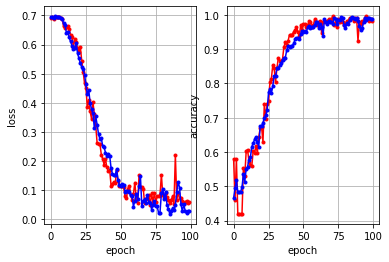

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
    ])
    
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=100)
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.setp(ax1, xlabel='epoch', ylabel='loss')

ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')

plt.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 64)       

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 500; //video.videoWidth;
      canvas.height = 500; //video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


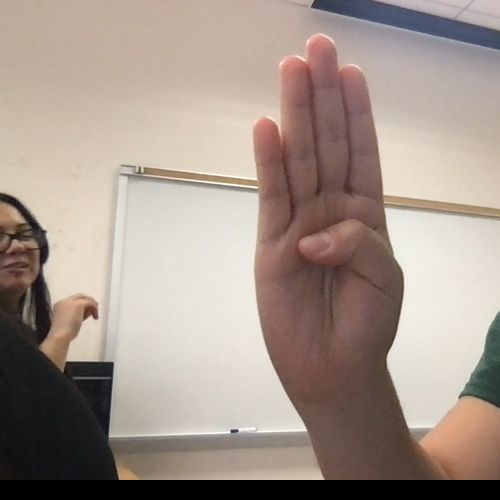

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

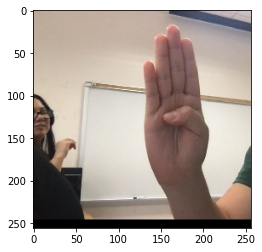

This image most likely belongs to b with a 97.32 percent confidence.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

testimage_path = "photo.jpg"

img = tf.keras.utils.load_img(
    testimage_path, target_size=(256, 256)
)

plt.imshow(img)
plt.show()

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)